# Simulation of the growth and development of an apple tree 2 - Architecture

In [1]:
import namedenum ; reload(namedenum)
from namedenum import enum
import numpy as np

gutypes = enum('ShortGU', 'LongGU', 'Inflo', 'TrunkGU')
gufate  = enum('Proleptic','Sylleptic','Blind')

def is_sylleptic(gufate):
    return gufate == Sylleptic

def is_proleptic(gufate):
    return gufate == Proleptic
    

    

## Growth unit succession and flowering among years

In [60]:
sucessiontypes = [ShortGU, LongGU, Inflo]
successionmatrix = [[0.6,  0.0,  0.4],
                    [0.35, 0.25, 0.4],
                    [0.95, 0.05,  0]
                   ]
#from random import uniform, seed
from numpy import cumsum
from numpy.random import uniform


def realization_in_probaranges(probas):
    cumsum_probs = cumsum(probas)
    totalprob = cumsum_probs[-1]
    cumsum_probs /= totalprob
    assert abs(cumsum_probs[-1] -1) < 1e-5
    unif_realization = float( uniform(0,1) )
    i = 0
    while unif_realization >= cumsum_probs[i] : i += 1
    return i

def succession(gutype):
    if gutype == TrunkGU : return LongGU
    probas = successionmatrix[gutype]
    return sucessiontypes[realization_in_probaranges(probas)]


Inflo
ShortGU
Succession Probabilities


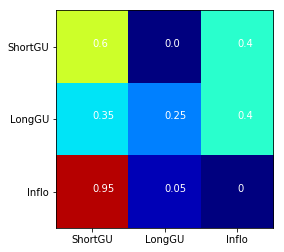

In [61]:
# Example of Use

print succession(LongGU)
print succession(Inflo)

print 'Succession Probabilities'
from matplotlib.pyplot import *
imshow(successionmatrix, cmap='jet', vmin = 0, vmax = 1)
xticks(range(3),map(str,sucessiontypes))
yticks(range(3),map(str,sucessiontypes))
for i in xrange(3):
    for j in xrange(3):
        text(i,j,str(successionmatrix[j][i]), color='w')
show()

## Branching probability

In [64]:
def normalize(matrix):
    def nml(a):
        s = sum(a)
        return a/s
    matrix = np.array(matrix)
    return np.array([nml(probas) for probas in matrix])
    
lateralfates = [Blind, Proleptic, Sylleptic]
branchingmatrixfate = normalize([
    [0.4,0.6,0],
    [0.3,0.7,0],
    [0.4,0.6,0],
    [0.7,0.3,0],
    [0.4,0.25,0.35],
    [0.4,0.25,0.35],
    [0.35,0.2,0.45],
    [0.35,0.3,0.35],
    [0.3,0.55,0.15],
    [0.65,0.35,0]
])

branchingmatrixfate2 = normalize([
    [0.0,0,1.0],
    [0.0,0,1.0],
    [0.0,0,1.0],
    [0.0,0,1.0],
    [0.0,0,1.0],
    [0.0,0,1.0],
    [0.0,0,1.0],
    [0.0,0,1.0],
    [0.0,0,1.0],
    [0.0,0,1.0]
])


lateraltypes = [ShortGU, LongGU, Inflo]
branchingmatrixtype = normalize([
    [0.5,0.5,0],
    [0.5,0.5,0],
    [0.75,0.25,0],
    [1,0,0],
    [1,0,0],
    [0.5,0.5,0],
    [0.25,0,0.75],
    [0.15,0.35,0.5],
    [0.15,0.7,0.15],
    [0.4,0.6,0]
])

branchingmatrixtype = np.array(branchingmatrixtype)

def branching(gutype, u, branchingmatrixfate = branchingmatrixfate, branchingmatrixtype = branchingmatrixtype):
    if gutype in [ShortGU, Inflo] : return Blind, None
    i, _ = divmod(u, 0.1)
    probafate = branchingmatrixfate[int(i)]
    fate = lateralfates[realization_in_probaranges(probafate)]
    if fate == Blind: return Blind, None
    probatype = branchingmatrixtype[int(i)]
    ptype = lateraltypes[realization_in_probaranges(probatype)]
    if fate == Sylleptic and ptype == Inflo:
        fate = Proleptic
    return fate, ptype

from matplotlib.pyplot import *
def plot_matrix(matrix, labels):
    imshow(matrix, cmap='jet', vmin = 0, vmax = 1)
    xticks(range(len(labels)),map(str,labels),rotation=90)
    nb = len(matrix)
    yticks(range(nb),map(str,[0.1*i for i in range(nb)]))
    for i in xrange(len(labels)):
        for j in xrange(nb):
            text(i-0.5,j,str(matrix[j][i]), color='w')
    show()
    

Branching Fate Probabilities 


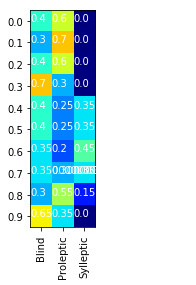

Branching Type Probabilities


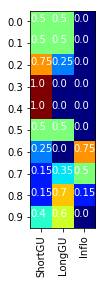

In [65]:
# Example of Use

print 'Branching Fate Probabilities '
plot_matrix(branchingmatrixfate, lateralfates)


print 'Branching Type Probabilities'
plot_matrix(branchingmatrixtype, lateraltypes)


In [39]:
def probalong(u,maxrank = 0.5, probamax = 0.5, rankspan = 0.5):
    if maxrank < 0: maxrank = 0
    elif maxrank >=1 : maxrank = 0.9
    if rankspan > 0.5 : rankspan = 0.5
    elif rankspan < 0 : rankspan = 0
    
    minu = maxrank-rankspan
    maxu = maxrank+rankspan
    if minu < -0.1:
        maxu = maxu-minu
        minu = -0.1
    if maxu > 1:
        minu -= (maxu-1)
        maxu = 1
    
    if u < minu or u > maxu:
        return 0
    if u < maxrank:
       return probamax*(u-minu)/(maxrank-minu)
    else:
       return probamax*(maxu-u)/(maxu-maxrank)
    

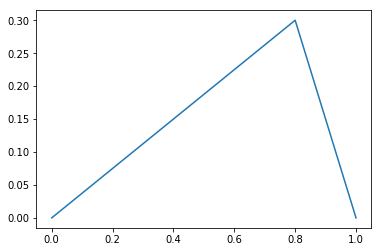

In [67]:
from numpy import arange
plot(arange(0,1.01,0.1),map(lambda u: probalong(u, 0.8, probamax=0.3,rankspan=0.8),arange(0,1.01,0.1)))
show()

In [34]:
def estimatebranchingmatrixtype(maxrank = 0.5, probamax = 0.5, rankspan = 0.5):
    longs = [probalong(u, maxrank, probamax, rankspan) for u in np.arange(0,1,0.1)]
    shorts = branchingmatrixtype[:,0]
    inflos = branchingmatrixtype[:,2]
    def normalizeprobas(a,b,c):
        f = (1-b)/(a+c)
        ap = a*f
        cp = c*f
        return (ap,b,cp)
    matrix = [normalizeprobas(a,b,c) for a,b,c in zip(shorts,longs, inflos)]
    return matrix
    
    
    

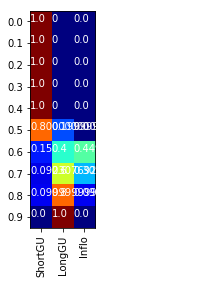

In [42]:
matrix = estimatebranchingmatrixtype(0.9, 1, 0.3)
plot_matrix(matrix, lateraltypes)

## Modelling architecture development

Open in L-Py [the model architecture.lpy](./architecture.lpy).

- Change Probability of succession and  branching
- Add rule for flowering GU that always create a lateral short GU and a Flower in terminal position.


# Pipe model

Radius of each internode depends of the number of descendants. 

<center>
    $r_i = r_0 . n_i^{p}$
</center>
with $n_i$ the number of descendants of internode $i$, $r_0$ the radius of the extremity and $p$ the pipe exponent.

Open the model [pipemodel.lpy](./pipemodel.lpy) and test different value of $r_0$ and $p$.